#  Projekt - Detektor mowy nienawiści we wpisach internetowych

Projekt skupia się na budowie modelu klasyfikacji tekstu, który ma zdolność identyfikacji mowy nienawiści we wpisach społecznościowych, a w szczególności w tweetach.
Kluczowe elementy projektu obejmują zastosowanie modelu LSTM, skrupulatną obróbkę danych, tokenizację i wykorzystanie mechanizmu early stoppingu. Projekt ma na celu efektywne identyfikowanie treści szkodliwych w przestrzeniach internetowych.

In [1138]:
import torch
cuda_available = torch.cuda.is_available()

In [1139]:
if cuda_available:
    gpu_name = torch.cuda.get_device_name(0)
gpu_name

'Tesla T4'

## Importowanie i oczyszczanie danych

In [1140]:
import pandas as pd
data = pd.read_csv("train.csv")

In [1141]:
data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Zostawiamy tylko dwie interesujące na kolumny

In [1142]:
data = data[['class', 'tweet']]

In [1143]:
data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [1144]:
data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

### Grupujemy dane według klasy, losowo próbkujemy tak, aby każda klasa miała tyle samo obserwacji (1430)

In [1145]:
data = data.groupby('class').apply(lambda x: x.sample(n = 1430)).sample(frac=1).reset_index(drop=True)

In [1146]:
data.head()

,class,tweet
0,0,RT @DestroTheNoble: I don't support that ya id...
1,0,You a hoe if you crying because yo ass pregnan...
2,2,RT @UFlorida: @GatorZoneFB It's a bird...It's ...
3,1,"RT @_naptural_: ""@NoBeeetch: When you drop all..."
4,2,Regular joes rockin tha boat that's us redneck...


In [1147]:
nclass = data['class'].nunique()
data['class'].value_counts()

0    1430
2    1430
1    1430
Name: class, dtype: int64

### Kodowanie klas za pomocą one-hot encoding

In [1148]:
import torch.nn.functional as F

class_ohe = F.one_hot(torch.as_tensor(data['class']), num_classes=nclass) # 0 -> [1,0,0] 1 -> [0,1,0] 2 -> [0,0,1]
data['class_ohe'] = [class_ohe[i] for i in range(len(data))]

In [1149]:
data.head()

,class,tweet,class_ohe
0,0,RT @DestroTheNoble: I don't support that ya id...,"[tensor(1), tensor(0), tensor(0)]"
1,0,You a hoe if you crying because yo ass pregnan...,"[tensor(1), tensor(0), tensor(0)]"
2,2,RT @UFlorida: @GatorZoneFB It's a bird...It's ...,"[tensor(0), tensor(0), tensor(1)]"
3,1,"RT @_naptural_: ""@NoBeeetch: When you drop all...","[tensor(0), tensor(1), tensor(0)]"
4,2,Regular joes rockin tha boat that's us redneck...,"[tensor(0), tensor(0), tensor(1)]"


In [1150]:
import re # regex to detect username, url, html entity
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
import string

### Oczyszczenie tweetów z różnych elementów:
### znaków interpunkcyjnych, nazw użytkowników, emoji, adresów URL, dużych liter, stopwords


In [1151]:
punctuation_dict = dict.fromkeys(string.punctuation, "") # {'!': '', '"': '', '#': '', ... , '|': '', '}': '', '~': ''}
punctuation_dict['\n'] = ""
translation_table = str.maketrans(punctuation_dict)

In [1152]:
def preprocess(data):
    clean = [tweet.lower() for tweet in data]

    clean = [re.sub(r"@([^ ]+)", "user", tweet) for tweet in clean] # change @xxx to user in all tweets

    clean = [re.sub(r"&[^\s;]+;", "", tweet) for tweet in clean] # remove emojis (html entity)

    clean = [re.sub(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))",
                    "", tweet) for tweet in clean] # remove url in all tweets

    clean = [tweet.translate(translation_table) for tweet in clean] # remove punctuation

    return clean

In [1153]:
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(data):
    stop_words = set(stopwords.words('english')) # stopwords like "the", "a", "my", "shouldn't", ...
    stop_words = [word.translate(translation_table) for word in stop_words]
    stop_words.append("rt") # rt means retweet

    clean = []
    for tweet in data:
        tokenize = nltk.word_tokenize(tweet) # create list of words in tweet
        tweet = [word for word in tokenize if not word in stop_words] # omit stopwords
        tweet = " ".join(tweet) # joins list to create tweet

        clean.append(tweet)

    return clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1154]:
cleaned_data = preprocess(data['tweet'])
data['clean'] = remove_stopwords(cleaned_data)

In [1155]:
data.head()

,class,tweet,class_ohe,clean
0,0,RT @DestroTheNoble: I don't support that ya id...,"[tensor(1), tensor(0), tensor(0)]",user support ya idiot im teabagger teabagged o...
1,0,You a hoe if you crying because yo ass pregnan...,"[tensor(1), tensor(0), tensor(0)]",hoe crying yo ass pregnant smiles riding dick ...
2,2,RT @UFlorida: @GatorZoneFB It's a bird...It's ...,"[tensor(0), tensor(0), tensor(1)]",user user birdits planeits jake mcgee
3,1,"RT @_naptural_: ""@NoBeeetch: When you drop all...","[tensor(0), tensor(1), tensor(0)]",user user drop hoes wrong one got ta bring em ...
4,2,Regular joes rockin tha boat that's us redneck...,"[tensor(0), tensor(0), tensor(1)]",regular joes rockin tha boat thats us redneck ...


### Podział danych na zbiór treningowy i tymczasowy

In [1156]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(data, test_size=0.149, random_state=42)
train_data = train_data[:-2]

train_data = train_data.reset_index(drop=True)
print(len(train_data), len(temp_data))

3648 640


In [1157]:
train_data.head(2)

,class,tweet,class_ohe,clean
0,0,RT @sblmnl_crmnl: @woods_lamar shut your nigge...,"[tensor(1), tensor(0), tensor(0)]",user user shut nigger ass lamar
1,0,Happy first day of college nigger @MorbidMermaid,"[tensor(1), tensor(0), tensor(0)]",happy first day college nigger user


### Tokenizacja tweetów w zbiorze treningowym (dzielenie na listy słów)

In [1158]:
from torchtext.data.utils import get_tokenizer
import torchtext.vocab

tokenizer = get_tokenizer("basic_english") # get basic tokenizer (lowercase, separate punctuation from words)
def tokenize(tweets):
    return [tokenizer(tweet) for tweet in tweets]

In [1159]:
train_data['tokenized'] = tokenize(train_data['clean'])

In [1160]:
train_data.head(2)

,class,tweet,class_ohe,clean,tokenized
0,0,RT @sblmnl_crmnl: @woods_lamar shut your nigge...,"[tensor(1), tensor(0), tensor(0)]",user user shut nigger ass lamar,"[user, user, shut, nigger, ass, lamar]"
1,0,Happy first day of college nigger @MorbidMermaid,"[tensor(1), tensor(0), tensor(0)]",happy first day college nigger user,"[happy, first, day, college, nigger, user]"


### Budowa słownika z tokenów pochodzących z danych treningowych

In [1161]:
vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokenized'],
                                                  min_freq=3, specials=['<pad>', '<unk>']) # use 0 for padding, 1 for unknown
vocab.set_default_index(1) # set the default index for unknown words
vocab_size = len(vocab) # 1766

### Przekształcanie listy tokenów w zbiorze treningowym na odpowiadające im listy tensorów PyTorch zawierających indeksy słów (zdefiniowane w słowniku)

In [1162]:
def indice(tweets):
    return [torch.tensor([vocab[word] for word in tweet]) for tweet in tweets]

In [1163]:
train_data['indices'] = indice(train_data['tokenized'])

In [1164]:
train_data.head(2)

,class,tweet,class_ohe,clean,tokenized,indices
0,0,RT @sblmnl_crmnl: @woods_lamar shut your nigge...,"[tensor(1), tensor(0), tensor(0)]",user user shut nigger ass lamar,"[user, user, shut, nigger, ass, lamar]","[tensor(2), tensor(2), tensor(109), tensor(24)..."
1,0,Happy first day of college nigger @MorbidMermaid,"[tensor(1), tensor(0), tensor(0)]",happy first day college nigger user,"[happy, first, day, college, nigger, user]","[tensor(145), tensor(161), tensor(73), tensor(..."


In [1165]:
max_length = max(len(tweet) for tweet in train_data['indices']) # length of padding
max_length

25

### Ujednolicanie długości wejściowej elementów zbioru treningowego (dopełnianie zerami do max. długości)

In [1166]:
from torch.nn.utils.rnn import pad_sequence

def pad_to_max_length(tweets, max_length):
    pad = pad_sequence([torch.cat([seq, torch.zeros(max_length - len(seq))]) for seq in tweets], batch_first=True)
    return [pad[i] for i in range(len(pad))]
train_data['padded'] = pad_to_max_length(train_data['indices'], max_length)

In [1167]:
train_data.head(2)

,class,tweet,class_ohe,clean,tokenized,indices,padded
0,0,RT @sblmnl_crmnl: @woods_lamar shut your nigge...,"[tensor(1), tensor(0), tensor(0)]",user user shut nigger ass lamar,"[user, user, shut, nigger, ass, lamar]","[tensor(2), tensor(2), tensor(109), tensor(24)...","[tensor(2.), tensor(2.), tensor(109.), tensor(..."
1,0,Happy first day of college nigger @MorbidMermaid,"[tensor(1), tensor(0), tensor(0)]",happy first day college nigger user,"[happy, first, day, college, nigger, user]","[tensor(145), tensor(161), tensor(73), tensor(...","[tensor(145.), tensor(161.), tensor(73.), tens..."


In [1168]:
train_data['padded'][0]

tensor([  2.,   2., 109.,  24.,   9.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.])

### Oczyszczanie danych w ten sam sposób, tylko dla zbioru tymczasowego - potem podzielenie go na zbiór walidacyjny i testowy

In [1169]:
def conversion(df):
    df['tokenized'] = tokenize(df['clean'])
    df['indices'] = indice(df['tokenized'])
    df['padded'] = pad_to_max_length(df['indices'], max_length)
    return df

In [1170]:
temp_data = conversion(temp_data)

In [1171]:
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [1172]:
val_data.head(2)

,class,tweet,class_ohe,clean,tokenized,indices,padded
0,0,Chill RT @PhillyTheBoss If I ever become presi...,"[tensor(1), tensor(0), tensor(0)]",chill user ever become president imma ban henn...,"[chill, user, ever, become, president, imma, b...","[tensor(819), tensor(2), tensor(80), tensor(1)...","[tensor(819.), tensor(2.), tensor(80.), tensor..."
1,2,@jordan_luree @NatalieSchroyer me or nat!? &#1...,"[tensor(0), tensor(0), tensor(1)]",user user nat def shiner,"[user, user, nat, def, shiner]","[tensor(2), tensor(2), tensor(1), tensor(828),...","[tensor(2.), tensor(2.), tensor(1.), tensor(82..."


In [1173]:
test_data.head(2)

,class,tweet,class_ohe,clean,tokenized,indices,padded
0,1,RT @LaVintageTribe: Getting all these checks l...,"[tensor(0), tensor(1), tensor(0)]",user getting checks like nike im icy yo bitch ...,"[user, getting, checks, like, nike, im, icy, y...","[tensor(2), tensor(144), tensor(1), tensor(4),...","[tensor(2.), tensor(144.), tensor(1.), tensor(..."
1,0,RT @DefendWallSt: Tell me how you really feel....,"[tensor(1), tensor(0), tensor(0)]",user tell really feel user little isis faggots...,"[user, tell, really, feel, user, little, isis,...","[tensor(2), tensor(84), tensor(51), tensor(138...","[tensor(2.), tensor(84.), tensor(51.), tensor(..."


### Tworzenie DataLoaderów dla zbiorów treningowego, walidacyjnego i testowego  z rozmiarem batcha = 64

In [1174]:
from torch.utils.data import TensorDataset, DataLoader

def loader_maker(df, batch_size, is_train):
    d = [(i, t) for i, t in zip(df['padded'].values,  df['class_ohe'].values)]
    return DataLoader(d, batch_size=batch_size, shuffle=is_train)

In [1175]:
batch_size = 64

train_batches = loader_maker(train_data, batch_size, True)
val_batches = loader_maker(val_data, batch_size, False)
test_batches = loader_maker(test_data, batch_size, False)

### Definiowanie klasy modelu LSTM

In [1176]:
import torch
import torch.nn as nn

class LSTM_model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, h1, h2, output_size, max_length, dropout_rate):
        super(LSTM_model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, h1, dropout=dropout_rate, batch_first=True)
        self.lstm2 = nn.LSTM(h1, h1, batch_first=True)  # Dodanie drugiej warstwy LSTM

        self.seq = nn.Sequential(
            nn.Linear(h1, h2),
            nn.Tanh(),
            nn.BatchNorm1d(h2),
            nn.Dropout(dropout_rate),
            nn.Linear(h2, output_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out1, _ = self.lstm1(embedded)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = lstm_out2[:, -1, :]
        x = self.seq(lstm_out2)
        return x

In [1177]:
embedding_dim = 64 # usually 32, 64
h1 = 64 # power of 2
h2 = 32
dropout_rate = 0.3 # commonly used

In [1178]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Tworzenie obiektu klasy LSTM_model z określonymi parametrami

In [1179]:
model = LSTM_model(vocab_size, embedding_dim, h1, h2, nclass, max_length, dropout_rate)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_model(
  (embedding): Embedding(1743, 64)
  (lstm1): LSTM(64, 64, batch_first=True, dropout=0.3)
  (lstm2): LSTM(64, 64, batch_first=True)
  (seq): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

In [1180]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)
print(total_params); print(trainable_params)

180355
180355


In [1181]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Tworzenie funkcji trenowania, testowania oraz liczenia dokładności modelu

In [1182]:
def training(data_loader, model):
    model.train()
    total_loss = 0
    for i, (input, target) in enumerate(data_loader):
        input, target = input.to(device).int(), target.to(device).float()
        optimizer.zero_grad()
        prediction = model(input)
        loss = loss_function(prediction, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    return total_loss / (i + 1)

In [1183]:
def testing(data_loader, model):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (input, target) in enumerate(data_loader):
            input, target = input.to(device).int(), target.to(device).float()
            prediction = model(input)
            loss = loss_function(prediction, target)
            total_loss += loss.item()
    return total_loss / (i + 1)

In [1184]:
def calculate_accuracy(data_loader, model):
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for i, (input, target) in enumerate(data_loader):
            input, target = input.to(device).int(), target.to(device).float()

            # Pobieranie klas z one-hot encoding
            true_classes = torch.argmax(target, dim=1)

            # Pobierzanie przewidzianych klasy
            predictions = model(input)
            predicted_classes = torch.argmax(predictions, dim=1)

            # Porównanie przewidzianych klas z faktycznymi klasami
            correct_predictions += (predicted_classes == true_classes).sum().item()
            total_samples += target.size(0)

    accuracy = correct_predictions / total_samples * 100
    return accuracy

### Tworzenie funkcji Early Stopping

In [1185]:
class EarlyStopping:
    def __init__(self, patience=100, tolerance=10):
        self.tolerance = tolerance
        self.patience = patience
        self.best_val = 0
        self.wait_patience = 0
        self.wait = 0

    def update_best_val(self, currect_val):
        if self.wait_patience < self.patience:
            self.wait_patience += 1
        else:
          if currect_val <= self.best_val:
            self.best_val = currect_val
            self.wait = 0
          else:
            self.wait += 1

    def should_stop(self):
        return self.wait >= self.tolerance

### Przeprowadzanie treningu modelu

In [1186]:
epochs = 1000
training_losses, testing_losses = [], []
training_accuracies, testing_accuracies = [], []

early_stopping = EarlyStopping() #dodane

for epoch in range(epochs):

   # Trening
    t_loss = training(train_batches, model)
    training_losses.append(t_loss)

    # Obliczanie dokładności dla danych treningowych
    accuracy_train = calculate_accuracy(train_batches, model)
    training_accuracies.append(accuracy_train)

    # Walidacja
    v_loss = testing(val_batches, model)
    testing_losses.append(v_loss)

    # Obliczanie dokładności dla danych walidacyjnych
    accuracy_val = calculate_accuracy(val_batches, model)
    testing_accuracies.append(accuracy_val)

    # Aktualizacja najlepszych wag i sprawdzenie warunku zatrzymania
    early_stopping.update_best_val(v_loss)

    # Sprawdzenie warunku zatrzymania
    if early_stopping.should_stop():
        print(f"Epoch {epoch}")
        print(f"Train Loss: {t_loss:.4f}, Validation Loss: {v_loss:.4f}, Train Accuracy: {accuracy_train:.2f}%, Validation Accuracy: {accuracy_val:.2f}%")
        print(f"Early stopping triggered after {epoch} epochs.")
        break


    if (epoch) % 10 == 0:
      print(f"Epoch {epoch}")
      print(f"Train Loss: {t_loss:.4f}, Validation Loss: {v_loss:.4f}, Train Accuracy: {accuracy_train:.2f}%, Validation Accuracy: {accuracy_val:.2f}%")

Epoch 0
Train Loss: 1.0516, Validation Loss: 1.0030, Train Accuracy: 52.99%, Validation Accuracy: 51.25%
Epoch 10
Train Loss: 0.7252, Validation Loss: 0.7938, Train Accuracy: 83.47%, Validation Accuracy: 75.62%
Epoch 20
Train Loss: 0.6775, Validation Loss: 0.7793, Train Accuracy: 87.58%, Validation Accuracy: 76.88%
Epoch 30
Train Loss: 0.6672, Validation Loss: 0.7758, Train Accuracy: 88.76%, Validation Accuracy: 77.81%
Epoch 40
Train Loss: 0.6651, Validation Loss: 0.7956, Train Accuracy: 89.64%, Validation Accuracy: 75.62%
Epoch 50
Train Loss: 0.6478, Validation Loss: 0.7947, Train Accuracy: 90.57%, Validation Accuracy: 75.00%
Epoch 60
Train Loss: 0.6501, Validation Loss: 0.7943, Train Accuracy: 90.43%, Validation Accuracy: 75.62%
Epoch 70
Train Loss: 0.6354, Validation Loss: 0.8029, Train Accuracy: 91.31%, Validation Accuracy: 74.69%
Epoch 80
Train Loss: 0.6354, Validation Loss: 0.8008, Train Accuracy: 91.89%, Validation Accuracy: 75.00%
Epoch 90
Train Loss: 0.6326, Validation Loss: 0

### Wykres funkcji strat oraz dokładności dla zbioru treningowego i walidacyjnego

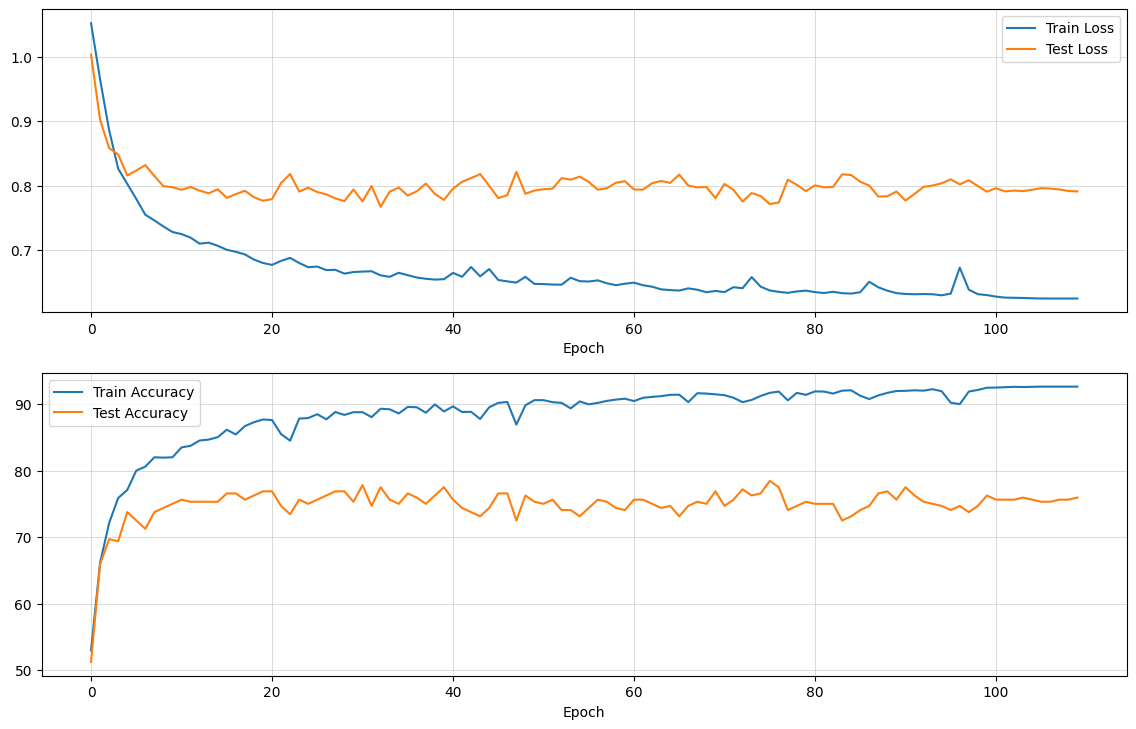

In [1187]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14/1.618))

ax1.plot(training_losses, label='Train Loss')
ax1.plot(testing_losses, label='Test Loss')
ax1.set_xticks(range(0, len(training_losses)+1, 20))
ax1.set_xlabel("Epoch")
ax1.grid(lw=0.5, color='gray', alpha=0.4)
ax1.legend()

# Dodaj drugi wykres dla dokładności
ax2.plot(training_accuracies, label='Train Accuracy')
ax2.plot(testing_accuracies, label='Test Accuracy')
ax2.set_xticks(range(0, len(training_accuracies)+1, 20))
ax2.set_xlabel("Epoch")
ax2.grid(lw=0.5, color='gray', alpha=0.4)
ax2.legend()

plt.show()

## Przewidywanie rodzaju wpisu

In [1188]:
def predict_if_hate(tweet):
  # Dostosowanie wpisu do formy właściwej dla modelu
  tweet = pd.DataFrame([tweet])
  tweet = preprocess(tweet[0])
  tweet = remove_stopwords(tweet)
  tweet = tokenize(tweet)
  tweet = indice(tweet)
  tweet = pad_to_max_length(tweet, max_length)
  tweet = torch.stack(tweet)
  with torch.no_grad():
    tweet = tweet.to(device).int()
    # Przewidywanie
    predictions = model(tweet)
    predicted_classes = torch.argmax(predictions, dim=1)
    value = torch.argmax(torch.bincount(predicted_classes)).item()
  if value == 0:
    return 'Hate speech'
  elif value == 1:
    return 'Offensive language'
  else:
    return'Neither hate nor offensive'

In [1189]:
tweet_1 = "@Maro19 you dumb fuck"
tweet_2 = "@Maro19 I like broccoli"
tweet_3 = "@Maro19 pillow talkin bitches see bad nigga basic"
print(predict_if_hate(tweet_1))
print(predict_if_hate(tweet_2))
print(predict_if_hate(tweet_3))

Hate speech
Neither hate nor offensive
Offensive language


In [1190]:
calculate_accuracy(test_batches, model)

75.3125